### One Baseline -- Autoencoder for Denoising GW

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
import os

In [2]:
from autoencoder_classes import Autoencoder01, Autoencoder02, Autoencoder04, Autoencoder06, Autoencoder08
from autoencoder_classes import Autoencoder1, Autoencoder2, Autoencoder4, Autoencoder6, Autoencoder8, Autoencoder10
from autoencoder_classes import Autoencoder3, Autoencoder5, Autoencoder7, Autoencoder9

In [3]:
def count_multiplications_per_sample_AE(model):
    total_mults = 0
    for m in model.modules():
        if isinstance(m, nn.Linear):
            mults = m.in_features * m.out_features
            total_mults += mults
    return total_mults

In [4]:
AUTOENCODER_CLASSES = {
    "Autoencoder01": Autoencoder01,
    "Autoencoder1": Autoencoder1,
    "Autoencoder02": Autoencoder02,
    "Autoencoder2": Autoencoder2,
    "Autoencoder04": Autoencoder04,
    "Autoencoder4": Autoencoder4,
    "Autoencoder06": Autoencoder06,
    "Autoencoder6": Autoencoder6,
    "Autoencoder08": Autoencoder08,
    "Autoencoder8": Autoencoder8,
    "Autoencoder10": Autoencoder10,
    "Autoencoder3": Autoencoder3,
    "Autoencoder5": Autoencoder5,
    "Autoencoder7": Autoencoder7,
    "Autoencoder9": Autoencoder9
}

# load GW data

In [5]:
manifold_type = 'gw'
path_prefix = '/data/shiyu/projects/MT/MT_code/GW'
data_path = f'{path_prefix}/GW_data'
save_dir = f"{path_prefix}/autoencoder_GW"
train_waves_filename = 'datawaves_100000_spinsFalse_nonuniform.npy'
test_waves_filename = 'datawaves_20000_spinsFalse_nonuniform.npy'

In [6]:
## load training waves
input_file = os.path.join(data_path, train_waves_filename)
train_waves = np.load(input_file)


X_natural_train = train_waves
N_train = X_natural_train.shape[0]
D = X_natural_train.shape[1]
d = 2


sigma = 0.01    # noise standard deviation
X_train = X_natural_train + sigma * np.random.randn(*X_natural_train.shape)
X_train = torch.tensor(X_train, dtype=torch.float32)


print(f'X_train shape is {X_train.shape}')

X_train shape is torch.Size([100000, 2048])


In [7]:
## load test waves
test_input_file = os.path.join(data_path, test_waves_filename)
test_waves = np.load(test_input_file)


X_natural_test = test_waves
N_test = X_natural_test.shape[0]
X_test = X_natural_test + sigma * np.random.randn(*X_natural_test.shape)
X_test = torch.tensor(X_test, dtype=torch.float32)

print(f'X_test shape is {X_test.shape}')

X_test shape is torch.Size([20000, 2048])


# train Autoencoders

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
AEs_training_loss_per_sample_list = []
AEs_test_MSE_list = []
AEs_mults_per_sample_list = []

for name, model_class in AUTOENCODER_CLASSES.items():
    print(f'\nTraining {name}')
    model = model_class()
    model = model.to(device)
    criterion = nn.MSELoss(reduction='sum')
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    num_epochs  = 100
    batch_size = 256 #set batch_size as desired
    num_batches = N_train // batch_size
    num_samples_used = num_batches * batch_size


    training_loss_per_sample_list = []

    start_time = time.time()
    for epoch in range(num_epochs):
        loss_curr_epoch = 0
        for i in range(num_batches): 
            optimizer.zero_grad()

            start_index = i * batch_size
            end_index = start_index + batch_size
            batch_input = X_train[start_index : end_index].to(device)
            batch_output = model(batch_input)
            
            loss =  criterion(batch_output, batch_input) #### AE loss function
            loss.backward()
            optimizer.step()
            loss_curr_epoch += loss.item()

            
        training_loss_per_sample_curr_epoch = loss_curr_epoch / num_samples_used
        training_loss_per_sample_list.append(training_loss_per_sample_curr_epoch)

        print(f"epoch {epoch},{end_index} samples processed..., training loss per sample for the current epoch is {training_loss_per_sample_curr_epoch}")

    AEs_training_loss_per_sample_list.append(training_loss_per_sample_list)
        
    end_time = time.time()
    print(f"DONE... TOTAL TIME = {end_time - start_time}")
    torch.save(model.state_dict(), f'/data/shiyu/projects/MT/MT_code/GW/autoencoder_GW/saved_model_params/{name}.pth')
    


    # evaluation on test data
    print(f'start evaluation on test data for {name}')
    with torch.no_grad():
        X_test_denoised = model(X_test.to(device))

    test_MSE = np.sum((X_test_denoised.detach().cpu().numpy() - X_natural_test)**2) / N_test
    print(f'MSE on test data is {test_MSE}')
    AEs_test_MSE_list.append(test_MSE)


    AEs_mults_per_sample_list.append(count_multiplications_per_sample_AE(model))
    print('----------------------------------------------------------------------------------------------')



Training Autoencoder01
epoch 0,99840 samples processed..., training loss per sample for the current epoch is 117.1962201607533
epoch 1,99840 samples processed..., training loss per sample for the current epoch is 2.7071034744763987
epoch 2,99840 samples processed..., training loss per sample for the current epoch is 0.8807663153379391
epoch 3,99840 samples processed..., training loss per sample for the current epoch is 0.8638967292431073
epoch 4,99840 samples processed..., training loss per sample for the current epoch is 0.8631012140176235
epoch 5,99840 samples processed..., training loss per sample for the current epoch is 0.8629420304909731
epoch 6,99840 samples processed..., training loss per sample for the current epoch is 0.8629056516366127
epoch 7,99840 samples processed..., training loss per sample for the current epoch is 0.8628968463494228
epoch 8,99840 samples processed..., training loss per sample for the current epoch is 0.8628891707994999
epoch 9,99840 samples processed.

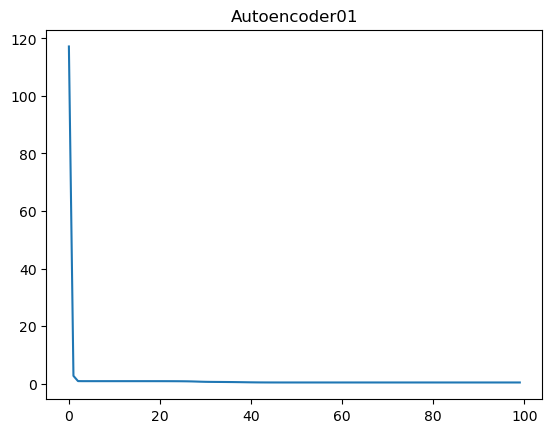

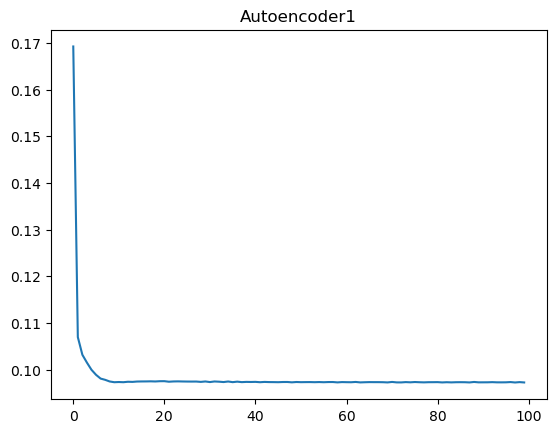

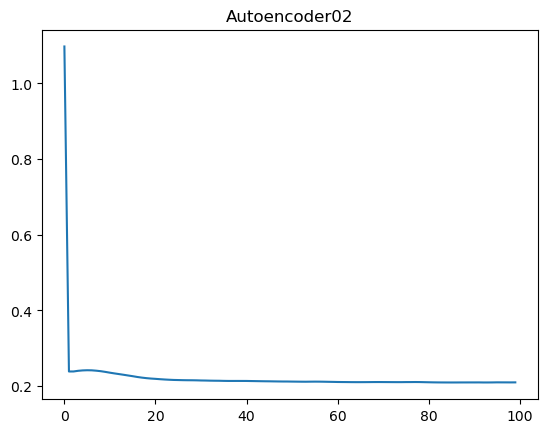

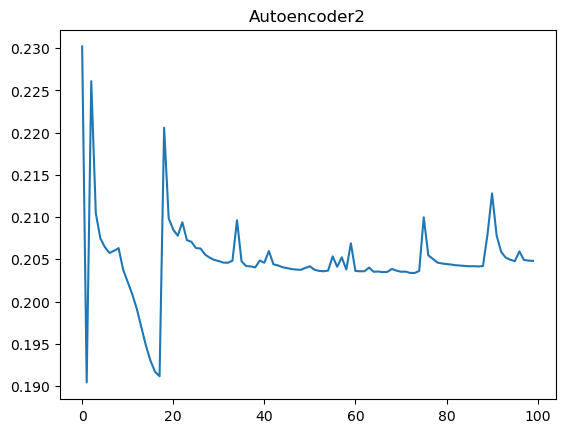

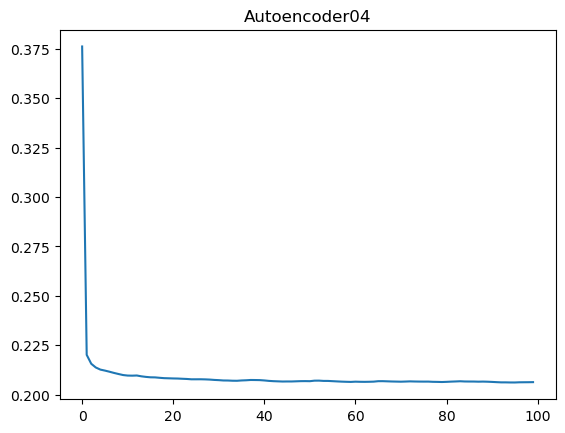

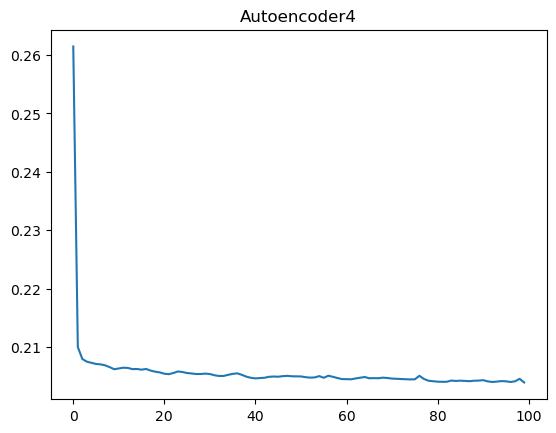

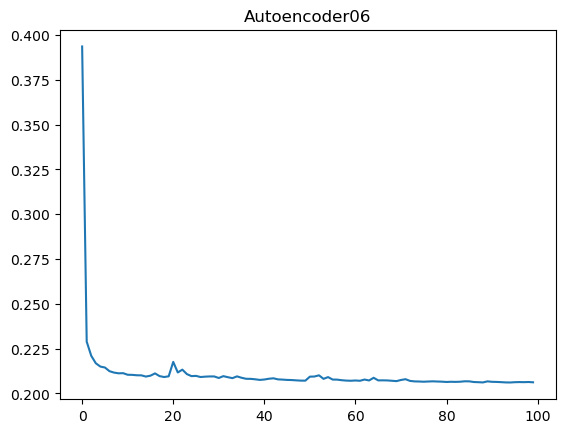

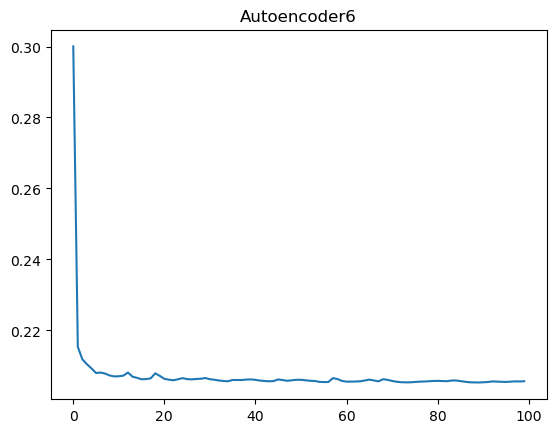

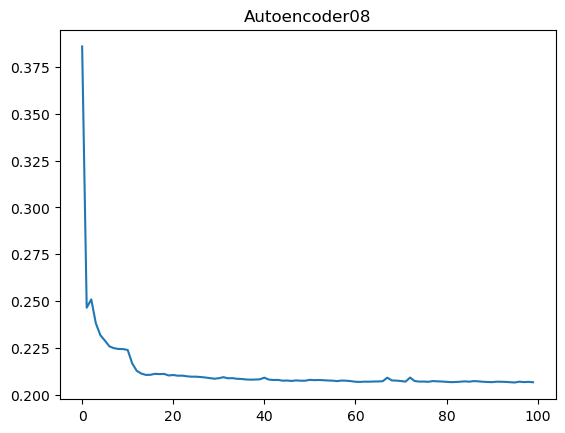

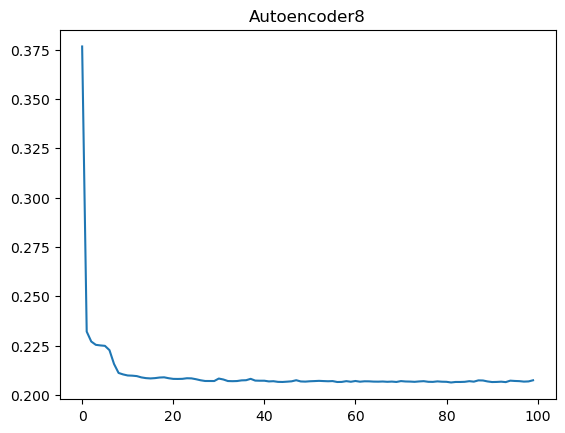

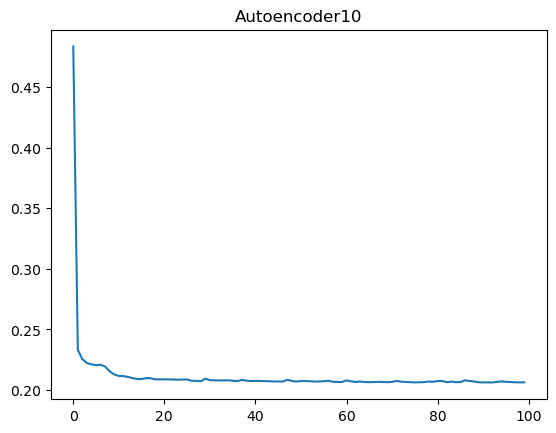

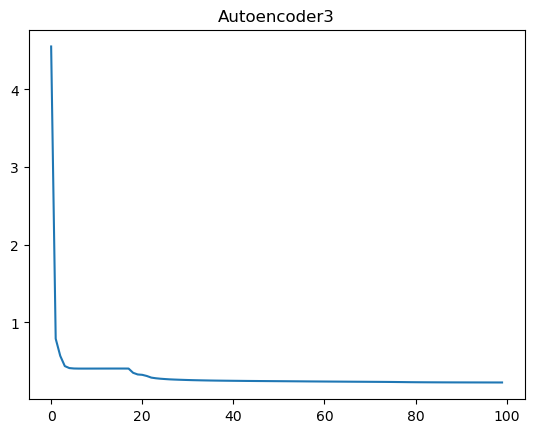

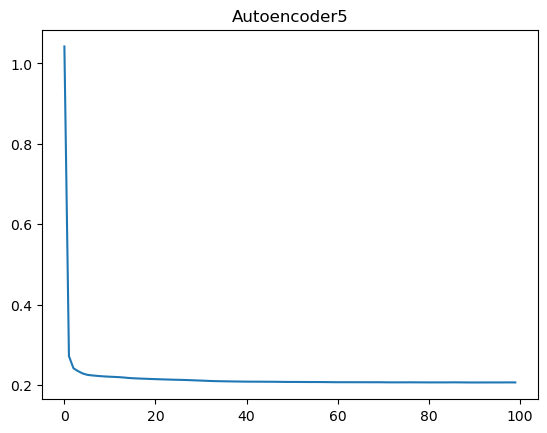

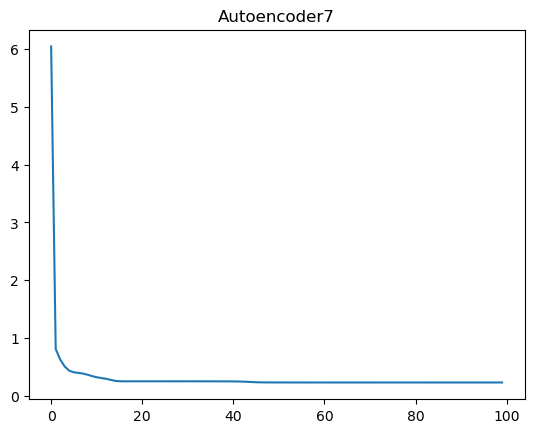

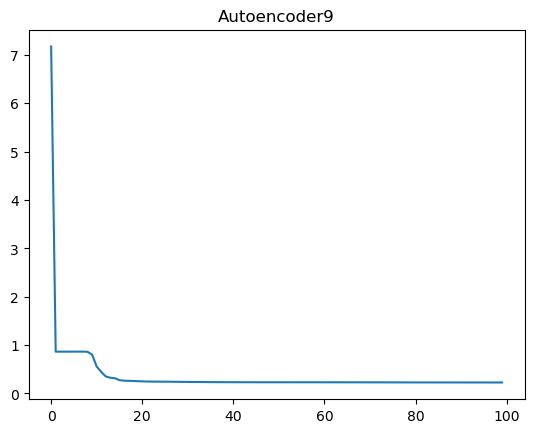

In [10]:
# plot training loss curve
for i, (key, value) in enumerate(AUTOENCODER_CLASSES.items()):
    plt.figure()
    plt.plot(AEs_training_loss_per_sample_list[i])
    plt.title(f'{key}')

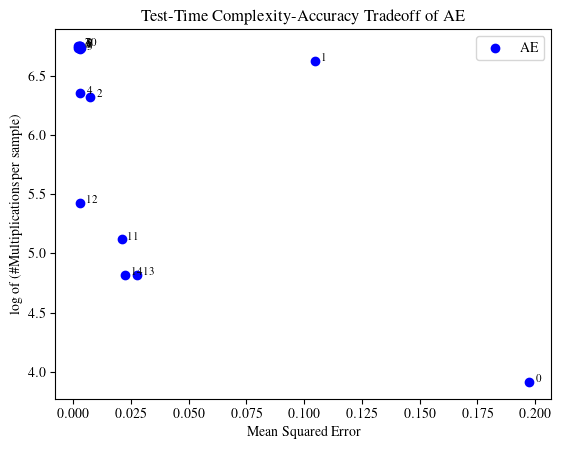

In [34]:
#plot trade-off curve for Autoencoders

for i in range(len(AEs_test_MSE_list)): 
    plt.scatter(AEs_test_MSE_list[i], np.log10(AEs_mults_per_sample_list[i]),  marker='o', color='blue')
    plt.text(AEs_test_MSE_list[i] + 0.003, np.log10(AEs_mults_per_sample_list[i]), str(i), fontsize=8) 


plt.title('Test-Time Complexity-Accuracy Tradeoff of AE')
plt.ylabel("log of (\#Multiplications per sample)")
plt.xlabel("Mean Squared Error")
plt.legend(['AE'])
plt.show()

In [36]:
for i, (name, model_class)in enumerate(AUTOENCODER_CLASSES.items()):
    print(f'i={i}, name={name}')

i=0, name=Autoencoder01
i=1, name=Autoencoder1
i=2, name=Autoencoder02
i=3, name=Autoencoder2
i=4, name=Autoencoder04
i=5, name=Autoencoder4
i=6, name=Autoencoder06
i=7, name=Autoencoder6
i=8, name=Autoencoder08
i=9, name=Autoencoder8
i=10, name=Autoencoder10
i=11, name=Autoencoder3
i=12, name=Autoencoder5
i=13, name=Autoencoder7
i=14, name=Autoencoder9


# MT on GW

In [12]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "..")))
from utils.utils_train import train_network_wrapper
from utils.utils_demo_growth import MT_perform_traversal

import pickle

In [13]:
def analyze_network(network_params, num_samples):
    
    # unpack data
    [local_params, nbrs_info, misc] = network_params
    (Q, T, S_collection, P, Xi)                = local_params
    (N1, W1, N0, W0)                           = nbrs_info
    (tangent_colors, D, d, M, P)               = misc

    print("Number of landmarks (M):", M)
    print("Number of first-order edges:", sum(len(inner_list) for inner_list in N1))
    print("Number of zero-order edges:", sum(len(inner_list) for inner_list in N0))
    print(f"Total Num Points Assigned to Network: {np.sum(np.array(P))}")



    Q_np = np.array(Q)

    mt_total_mults = 0
    mt_distces = []


    for i in range(num_samples):
        x= X_test[:,i]
        x_nat = X_natural_test[:,i]

        
        q_mt, _, _, _, mt_mults = MT_perform_traversal(x, Q, T, N1, W1,Xi, N0, W0, calc_mults=True)
        mt_total_mults += mt_mults

        SQdist_mt = np.sum((x_nat - Q[q_mt])**2)


        mt_distces.append(SQdist_mt)

        

    avg_mt_dist = np.sum(mt_distces) / num_samples
    avg_mt_mults = mt_total_mults / num_samples


    return (avg_mt_dist, avg_mt_mults)

In [14]:
#define training data for MT

X_train = X_train.detach().cpu().numpy().T
X_test = X_test.detach().cpu().numpy().T

X_natural_train = X_natural_train.T
X_natural_test = X_natural_test.T

print(f'X_train shape is {X_train.shape}')
print(f'X_test shape is {X_test.shape}')

X_train shape is (2048, 100000)
X_test shape is (2048, 20000)


In [15]:
# define MT hyperparams
R_is_const_list = [False,
                   True,
                   False,
                   True,
                   False,
                   False,
                   True,
                   False,
                   True,
                   True,
                   True,
                   True]

R_denoising_list = [np.sqrt(2.06 * sigma**2 * D),
                    np.sqrt(2.06 * sigma**2 * D),
                    np.sqrt(2.06 * sigma**2 * D),
                    np.sqrt(2.75 * sigma**2 * D),
                    np.sqrt(2.06 * sigma**2 * D),
                    np.sqrt(2.06 * sigma**2 * D),
                    np.sqrt(2.39 * sigma**2 * D),
                    np.sqrt(2.06 * sigma**2 * D),
                    np.sqrt(2 * sigma**2 * D),
                    np.sqrt(2.19 * sigma**2 * D),
                    np.sqrt(3.13 * sigma**2 * D),
                    np.sqrt(1.94 * sigma**2 * D)]

R_1st_order_nbrs_list = [np.sqrt(2.39 * sigma**2 * D),
                         np.sqrt(2.39 * sigma**2 * D),
                         np.sqrt(2.39 * sigma**2 * D),
                         np.sqrt(2.75 * sigma**2 * D),
                         np.sqrt(2.39 * sigma**2 * D),
                         np.sqrt(2.39 * sigma**2 * D),
                         np.sqrt(2.75 * sigma**2 * D),
                         np.sqrt(2.39 * sigma**2 * D),
                         np.sqrt(2.39 * sigma**2 * D),
                         np.sqrt(2.39 * sigma**2 * D),
                         np.sqrt(3.53 * sigma**2 * D),
                         np.sqrt(2.39 * sigma**2 * D)]

d_parallel_list = [np.sqrt(20 * sigma**2 * d),
                   np.sqrt(20 * sigma**2 * d),
                   np.sqrt(8 * sigma**2 * d),
                   np.sqrt(20 * sigma**2 * d),
                   np.sqrt(20 * sigma**2 * d),
                   np.sqrt(4 * sigma**2 * d),
                   np.sqrt(20 * sigma**2 * d),
                   np.sqrt(30 * sigma**2 * d),
                   np.sqrt(20 * sigma**2 * d),
                   np.sqrt(20 * sigma**2 * d),
                   np.sqrt(20 * sigma**2 * d),
                   np.sqrt(20 * sigma**2 * d)]

prod_coeff_list = [1.2,
                   1.2,
                   1.2,
                   1.2,
                   1.3,
                   1.15,
                   1.2,
                   1.5,
                   1.2,
                   1.2,
                   1.2,
                   1.2]

exp_coeff_list = [1/2,
                  1/2,
                  1/2,
                  1/2,
                  1/3,
                  1/2,
                  1/2,
                  1/2,
                  1/2,
                  1/2,
                  1/2,
                  1/2]

name_list = ["NETWORK_1",
             "NETWORK_2",
             "NETWORK_3",
             "NETWORK_4",
             "NETWORK_5",
             "NETWORK_6",
             "NETWORK_7",
             "NETWORK_8",
             "NETWORK_9",
             "NETWORK_10",
             "NETWORK_11",
             "NETWORK_12"]

network_params_list = []
errors_list = []

In [ ]:
#training MT network

for i in range(len(name_list)):
    print(f"TRAINING {name_list[i]}")
    network_params, errors = train_network_wrapper(R_is_const_list[i], R_denoising_list[i], R_1st_order_nbrs_list[i], d_parallel_list[i], prod_coeff_list[i], exp_coeff_list[i], name_list[i],
                                                   D, d, sigma,
                                                   N_train, X_train, X_natural_train, batch_size=4000)
    network_params_list.append(network_params)
    errors_list.append(errors)
    print("~~~~~~~~~~~~\n \n \n ")

TRAINING NETWORK_1
TOTAL TIME =  3.4478116035461426
4000 samples processed...
TOTAL TIME =  4.8515784740448
8000 samples processed...
TOTAL TIME =  6.136304616928101
12000 samples processed...
TOTAL TIME =  7.149404525756836
16000 samples processed...
TOTAL TIME =  7.928520202636719
20000 samples processed...
TOTAL TIME =  8.413670063018799
24000 samples processed...
TOTAL TIME =  8.897866010665894
28000 samples processed...
TOTAL TIME =  9.868887424468994
32000 samples processed...
TOTAL TIME =  10.224327087402344
36000 samples processed...
TOTAL TIME =  11.13943338394165
40000 samples processed...
TOTAL TIME =  12.06026029586792
44000 samples processed...
TOTAL TIME =  13.083435535430908
48000 samples processed...
TOTAL TIME =  13.017572402954102
52000 samples processed...
TOTAL TIME =  13.816899061203003
56000 samples processed...
TOTAL TIME =  14.02937650680542
60000 samples processed...
TOTAL TIME =  14.820660591125488
64000 samples processed...
TOTAL TIME =  15.716822624206543
68

In [17]:
#evaluation on test data

network_stats_list = []
for i in range(len(network_params_list)):
    print(f"Analyzing {name_list[i]}...")
    network_stats  = analyze_network(network_params_list[i], num_samples=N_test)
    print("DONE! \n \n")
    network_stats_list.append(network_stats)



MT_accuracies = [network_stats_list[i][0] for i in range(len(name_list))]
MT_complexities = [network_stats_list[i][1] for i in range(len(name_list))]


Analyzing NETWORK_1...
Number of landmarks (M): 1299
Number of first-order edges: 97109
Number of zero-order edges: 2044
Total Num Points Assigned to Network: 100000
DONE! 
 

Analyzing NETWORK_2...
Number of landmarks (M): 248
Number of first-order edges: 1062
Number of zero-order edges: 468
Total Num Points Assigned to Network: 100000
DONE! 
 

Analyzing NETWORK_3...
Number of landmarks (M): 2371
Number of first-order edges: 581073
Number of zero-order edges: 3310
Total Num Points Assigned to Network: 100000
DONE! 
 

Analyzing NETWORK_4...
Number of landmarks (M): 59
Number of first-order edges: 59
Number of zero-order edges: 127
Total Num Points Assigned to Network: 100000
DONE! 
 

Analyzing NETWORK_5...
Number of landmarks (M): 355
Number of first-order edges: 8047
Number of zero-order edges: 841
Total Num Points Assigned to Network: 100000
DONE! 
 

Analyzing NETWORK_6...
Number of landmarks (M): 2731
Number of first-order edges: 435299
Number of zero-order edges: 3819
Total Num

# plot

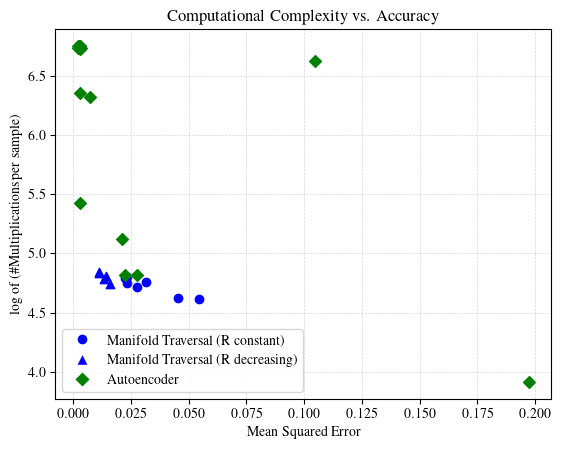

In [27]:
#plot comparison trade-off figure


from matplotlib.lines import Line2D

import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"]  # Using Times instead of Computer Modern to avoid font issues
})




for i in range(len(name_list)):
    marker_MT = 'o' if R_is_const_list[i] else '^'
    plt.scatter(MT_accuracies[i], np.log10(MT_complexities[i]), color='blue', marker=marker_MT)



for i in range(len(AEs_test_MSE_list)):
    plt.scatter(AEs_test_MSE_list[i], np.log10(AEs_mults_per_sample_list[i]), color='green', marker='D')


    
plt.xlabel("Mean Squared Error")
plt.ylabel("log of (\#Multiplications per sample)")
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Manifold Traversal (R constant)', markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='^', color='w', label='Manifold Traversal (R decreasing)', markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='D', color='w', label='Autoencoder', markerfacecolor='green', markersize=8)
]
plt.legend(handles=legend_elements)
plt.title('Computational Complexity vs. Accuracy')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.savefig(f'AE_MT_tradeoff.pdf')
plt.show()

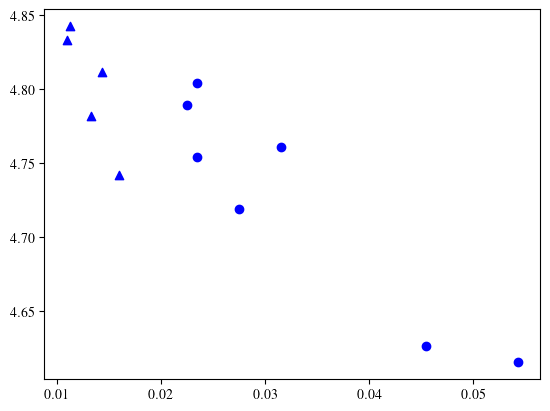

In [26]:

for i in range(len(name_list)):
    marker_MT = 'o' if R_is_const_list[i] else '^'
    plt.scatter(MT_accuracies[i], np.log10(MT_complexities[i]), color='blue', marker=marker_MT)
